In [1]:
"""
Created on Mon Apr 29 12:24:21 2019
A Scanpy pipeline for scRNAseq analysis, from the
2019 SCOG Hackathon. This version uses highly variable genes
to filter gene set
@author: tony
"""


'\nCreated on Mon Apr 29 12:24:21 2019\nA Scanpy pipeline for scRNAseq analysis, from the\n2019 SCOG Hackathon. This version uses highly variable genes\nto filter gene set\n@author: tony\n'

In [2]:
# impoirts
import scanpy as sc #for scanpy >= 1.3.7
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb


In [3]:
# Set up figures
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

# Data location (mtx file)
file_path = '/Users/SciCom/ScanPy/scRNAseqNeurons/neuron_10k_v3_raw_feature_bc_matrix.h5'
cc_genes_file = '/Users/SciCom/ScanPy/scRNAseqNeurons/Macosko_cell_cycle_genes.txt'


scanpy==1.4 anndata==0.6.18 numpy==1.15.2 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
# Define Marker genes
marker_genes = ['Fezf2','Vim','Sox2','C1qa','C1qc','Ptpn18','Tubb3','Gad2','Dlx5','Dlx1','Sst','Lhx6','Npas1','Mafb','Meis2','Adarb2','Mef2c','Cck','Dab1','Reln','Sstr2','Nrxn3']


In [5]:
# Load data, inspect
cc_genes_file = '/Users/SciCom/murineCellCycle.txt'
adata = sc.read_10x_h5(file_path)
adata.var_names_make_unique()
adata.shape
print('Total number of observations: {:d}'.format(adata.n_obs))

reading /Users/SciCom/ScanPy/scRNAseqNeurons/neuron_10k_v3_raw_feature_bc_matrix.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:07.27)
Total number of observations: 6794880


In [6]:
#preprocess and filter data
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['n_counts'].describe()
sc.pp.filter_cells(data = adata, min_counts = 30)
print('Total number of cells after removing empty droplets: {:d}'.format(adata.n_obs))

adata.obs['n_counts'].describe()
sc.pp.filter_cells(data = adata, min_counts = 100)
print('Total number of cells after removing empty droplets: {:d}'.format(adata.n_obs))


filtered out 6703280 cells that have less than 30 counts
Total number of cells after removing empty droplets: 91600
filtered out 52855 cells that have less than 100 counts
Total number of cells after removing empty droplets: 38745


... storing 'genome' as categorical
... storing 'feature_types' as categorical


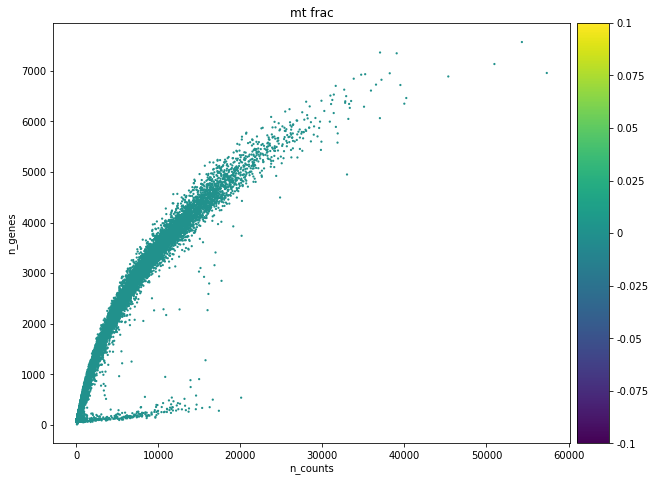

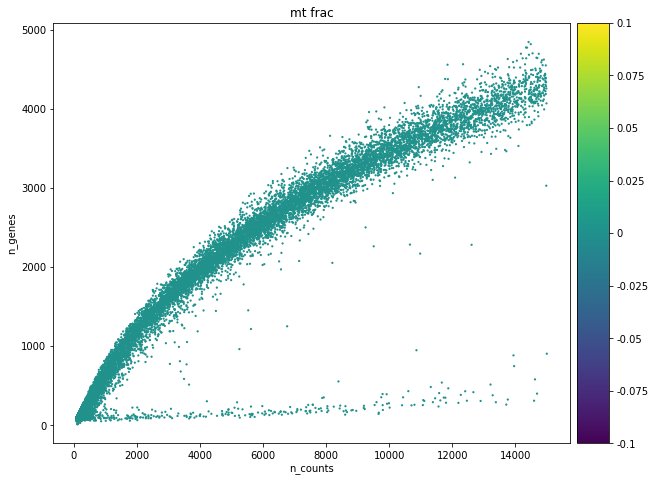

In [7]:
# Quality control - calculate QC covariates
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])

adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<15000], 'n_counts', 'n_genes', 
                   color='mt_frac', size=20)

/Users/SciCom/anaconda3/envs/myenv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


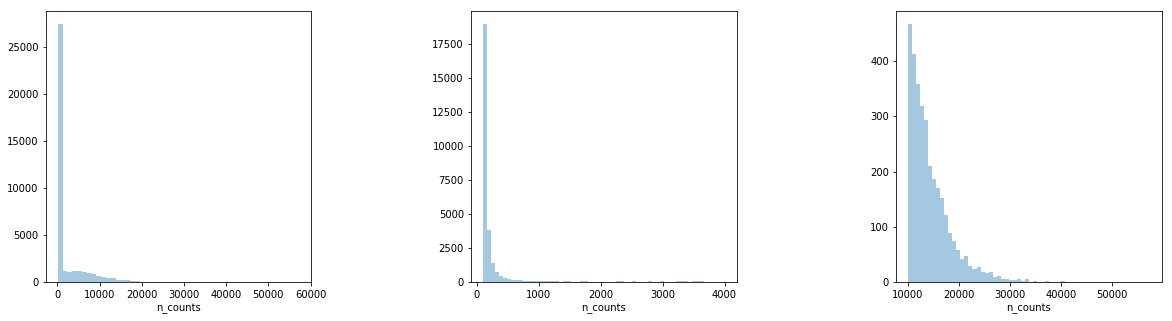

In [8]:
#Thresholding decision: counts
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

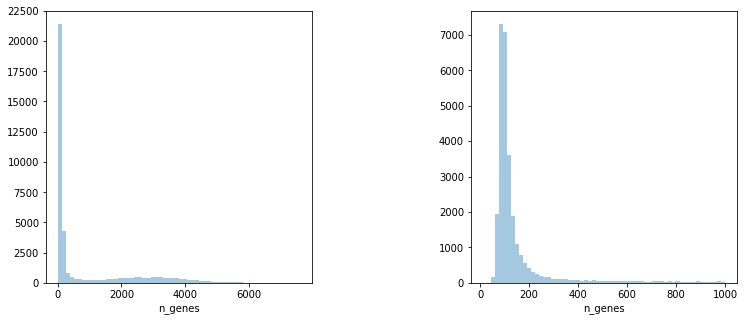

In [9]:
#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

/Users/SciCom/anaconda3/envs/myenv/lib/python3.5/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/SciCom/anaconda3/envs/myenv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


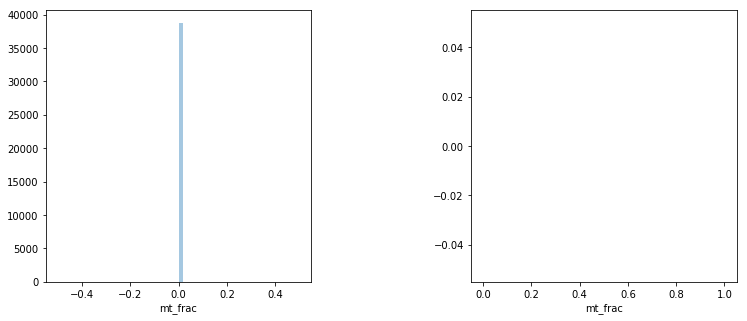

In [10]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.1], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()


Total number of cells: 38745
filtered out 27101 cells that have less than 1000 counts
Number of cells after min count filter: 11644
filtered out 318 cells that have more than  20000 counts
Number of cells after max count filter: 11326
Number of cells after MT filter: 11326
filtered out 477 cells that have less than 700 genes expressed
Number of cells after gene filter: 10849
Total number of genes: 31053
filtered out 16009 genes that are detected in less than 20 cells
Number of genes after cell filter: 15044
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 1999


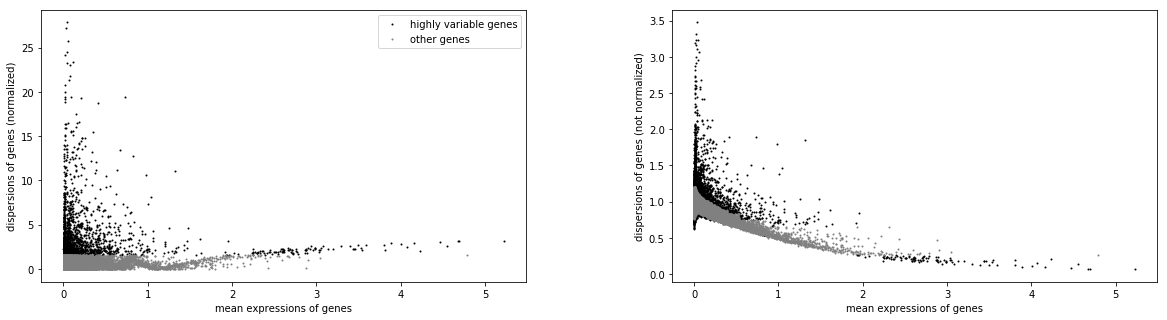

In [11]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 20000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:09.19) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:13.46) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    finished (0:00:06.92) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9976938  0.99576694 0.99501383 0.99295497 0.9885055
     0.98703945 0.98651737 0.9861207  0.98196125 0.9811877  0.97978806
     0.97836125 0.97451514 0.9711383 ]
    finished (0:00:00.33) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
drawing single-cell graph using layout "fa"
    finished (0:01:26.91) --> added
    'X

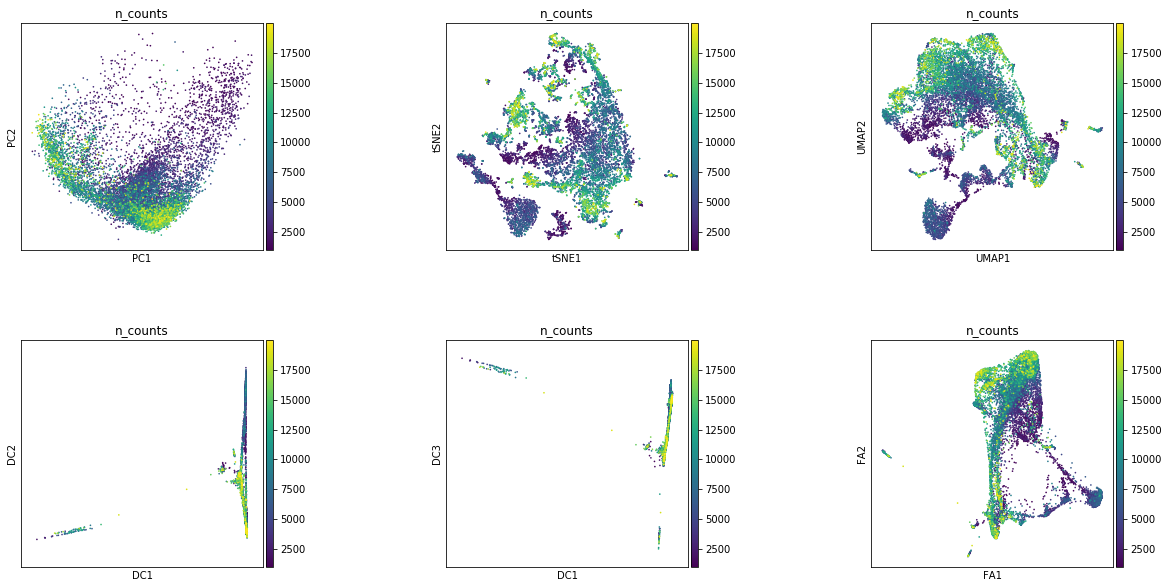

In [12]:
# Cluster and test embeddings
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs = 4) 
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
p13 = sc.pl.diffmap(adata, color='n_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]),show=False)
p14 = sc.pl.diffmap(adata, color='n_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
p15 = sc.pl.draw_graph(adata, color='n_counts', ax=fig.add_subplot(fig_ind[5]), show=False)

plt.show()

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:03.35) --> added
    'S_score', score of gene set (adata.obs)
computing score 'G2M_score'


... storing 'phase' as categorical


    finished (0:00:02.48) --> added
    'G2M_score', score of gene set (adata.obs)
-->     'phase', cell cycle phase (adata.obs)
114
108


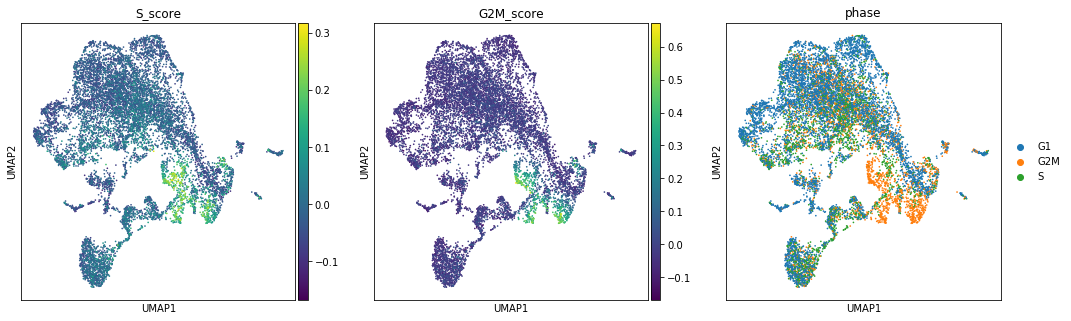

In [13]:
#Test for cell cycle influence
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_hvg = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes_hvg = adata.var_names[np.in1d(adata.var_names, g2m_genes)]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_hvg, g2m_genes=g2m_genes_hvg)
print(len(s_genes_hvg))
print(len(g2m_genes_hvg))

adata.obs['phase'].value_counts()
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['S_score', 'G2M_score','phase'], use_raw=False)


In [14]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

pd.crosstab(adata.obs['louvain_r0.5'], adata.obs['louvain_r1'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.17) --> found 22 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.07) --> found 16 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical)


louvain_r1       0    1    2    3    4    5    6    7    8    9 ...   12   13  \
louvain_r0.5                                                    ...             
0             1097    1    0    0   20    7  652    0    0  101 ...    0  323   
1               12  558    0    0  740    0    0    0    0    0 ...  413    0   
2                0    0  985    0    0    0    0    0    0    0 ...    0    0   
3                0    0    0  837    0    0    0    0    0    0 ...    0    0   
4                0    0    0    0    0  658    0    0    0   38 ...   13    0   
5                2    0    0    0    0    0    0    0    0    0 ...    0   12   
6                0    0    0    0    0    0    0  614    0    0 ...    0    0   
7                0    2    0    0    0    0    0    0  589    0 ...    0    0   
8                0    0    0    0    0    0    0    0    0    0 ...    0    0   
9                0  424    0    0    0    0    0    0    0    0 ...    0    0   
10               0    0    0    0    0    0    0    0    0    0 ...    0    0   
11               0    0    0    0    1    0    0    0    0    0 ...    0    0   
12               1    0    0    0    6    0    0    0    0  344 ...    2    0   
13               0    0    0    0    0    0    0    0    0    0 ...    0    0   
14               0    0    0    0    0    0    0    0    0    0 ...    0    0   
15               0    0    0    0    0    0    0    0    0    0 ...    0    0   

louvain_r1     14   15   16   17  18  19  20  21  
louvain_r0.5                                      
0               0    1    0    0   0   0   0   0  
1               0    0    0    0   0   0   0   0  
2              39    0    0    0   0   0   0   0  
3               0    0    0    0   0   0   0   0  
4               0    0    0    0   0   0   0   0  
5               0    0  308    0   0   0   0   0  
6               0    0    0    0   0   0   0   0  
7               0    0    0    0   0   0   0   0  
8             282    0    0  241   0   0   0   0  
9               0    0    0    0   0   0   0   0  
10              0  319    0    0   0  88   0   0  
11              0    0    0    0   0   0   0   0  
12              0    0    0    0   0   0   0   0  
13              0    0    0    0  99   0   0   0  
14              0    0    0    0   0   0  74   0  
15              0    0    0    0   0   0   0  40  

[16 rows x 22 columns]

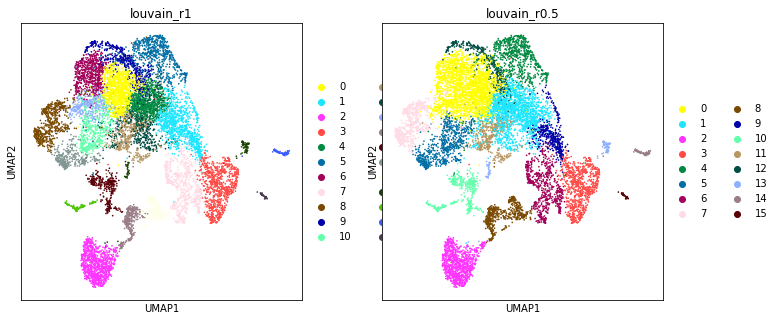

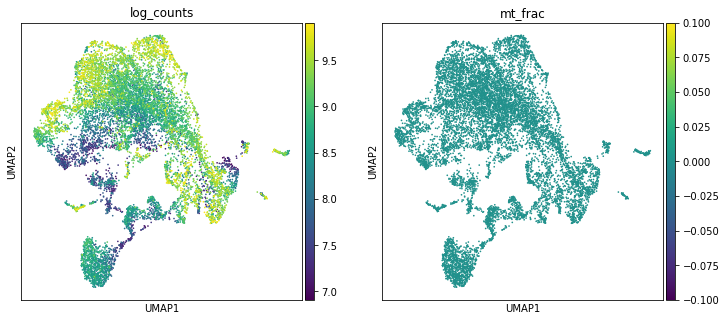

In [15]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

ranking genes
    finished (0:00:14.60) --> added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


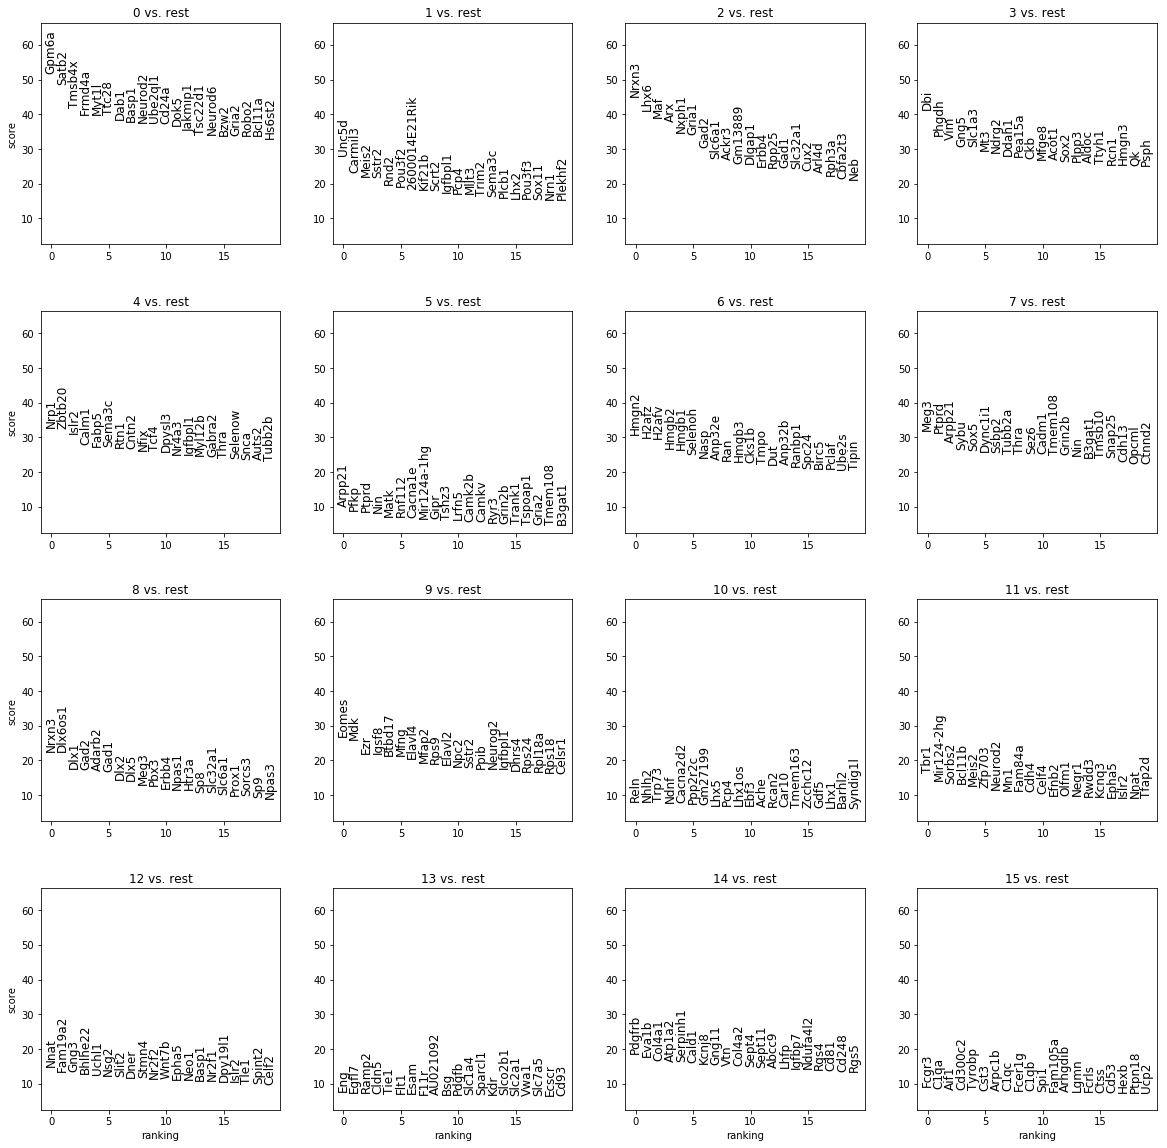

In [17]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)






ranking genes
    finished (0:00:18.81) --> added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


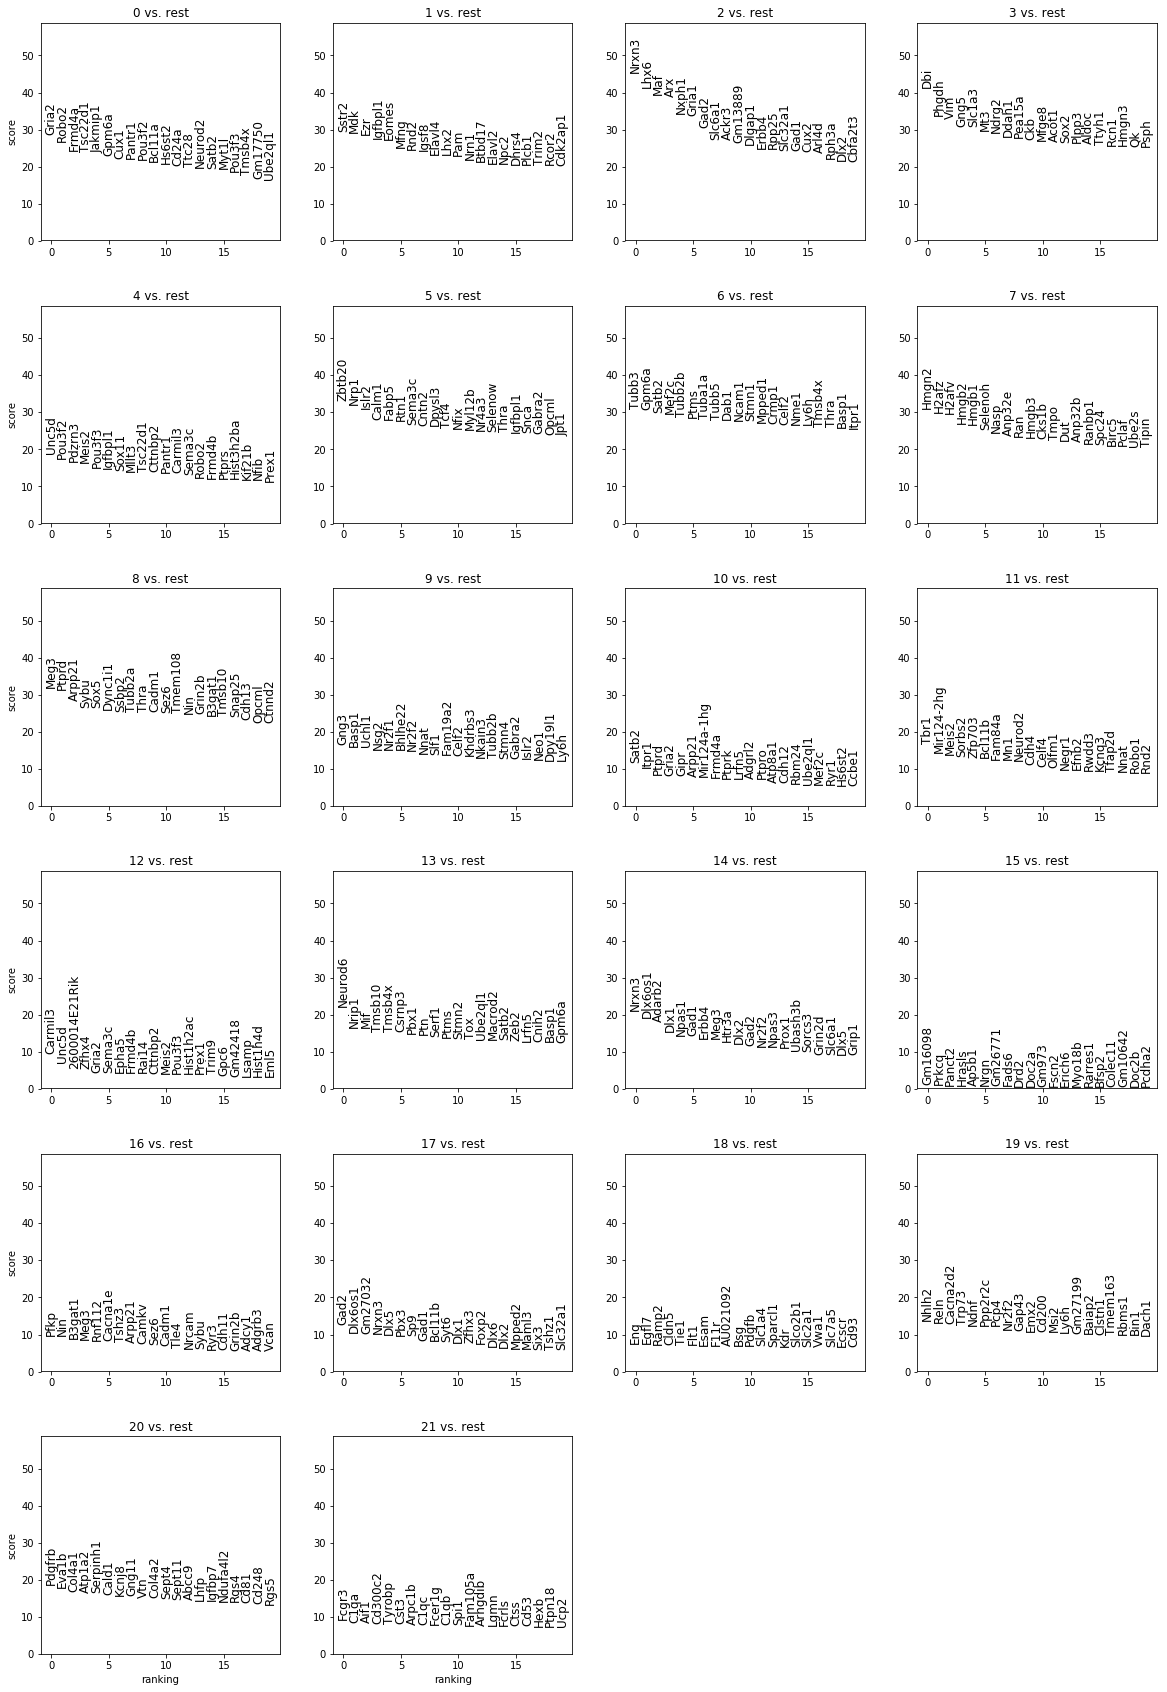

In [18]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', fontsize=12)


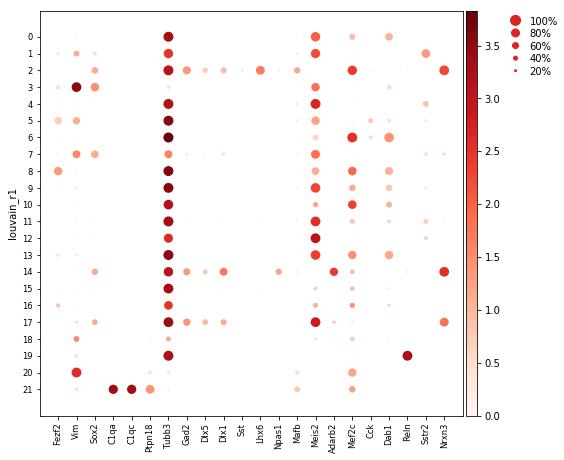

Divergent color map has been automatically set to plot non-raw data. Use `vmin`, `vmax` and `cmap` to adjust the plot.


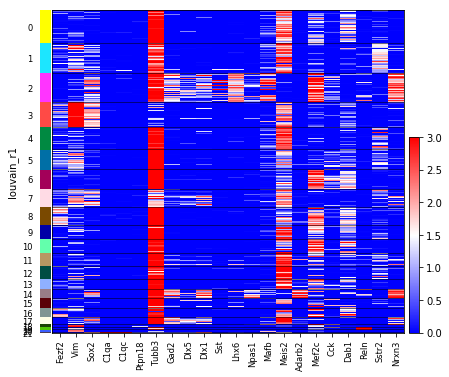

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 6.6, 0, 0.2])

In [19]:
#Plot marker genes


np.in1d(marker_genes, adata.var_names)

ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain_r1', use_raw=False)

sc.pl.heatmap(adata=adata, var_names=marker_genes, 
              groupby='louvain_r1', use_raw=False, vmin=0)

#ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1', use_raw=False)

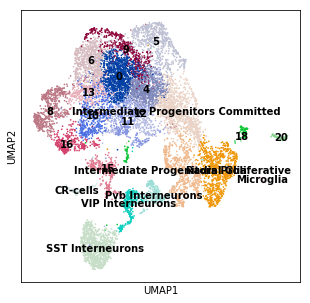

Divergent color map has been automatically set to plot non-raw data. Use `vmin`, `vmax` and `cmap` to adjust the plot.


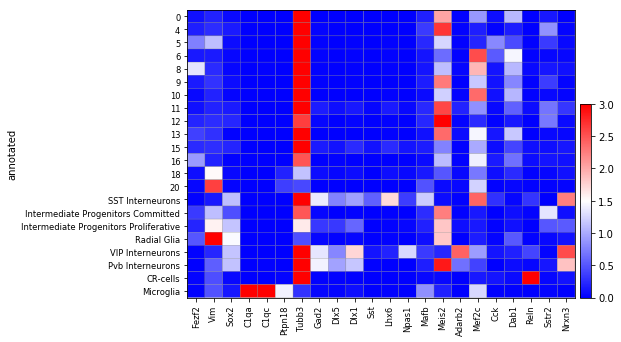

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[7.04, 0, 0.2])

In [20]:
# Annotate clusters according to marker gene expression
adata.obs['annotated'] = adata.obs['louvain_r1'].cat.add_categories(['SST Interneurons', 
                        'Intermediate Progenitors Committed', 'Intermediate Progenitors Proliferative', 'Radial Glia', 
                        'VIP Interneurons', 'Pvb Interneurons', 'CR-cells','Microglia'])


adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['1'])] = 'Intermediate Progenitors Committed'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['2'])] = 'SST Interneurons'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['3'])] = 'Radial Glia'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['14'])] = 'VIP Interneurons'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['17'])] = 'Pvb Interneurons'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['7'])] = 'Intermediate Progenitors Proliferative'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['19'])] = 'CR-cells'
adata.obs['annotated'][np.in1d(adata.obs['annotated'], ['21'])] = 'Microglia'

adata.obs['annotated'] = adata.obs['annotated'].cat.remove_unused_categories()
adata.obs['annotated'].value_counts()

sc.pl.umap(adata, color='annotated', legend_loc='on data', title='', frameon=True)

#ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1', use_raw=False)

sc.pl.matrixplot(adata, marker_genes, groupby='annotated', use_raw=False, vmin=0)

## Determine Interneuron subtypes
2 vs 14

ranking genes
    finished (0:00:00.44) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


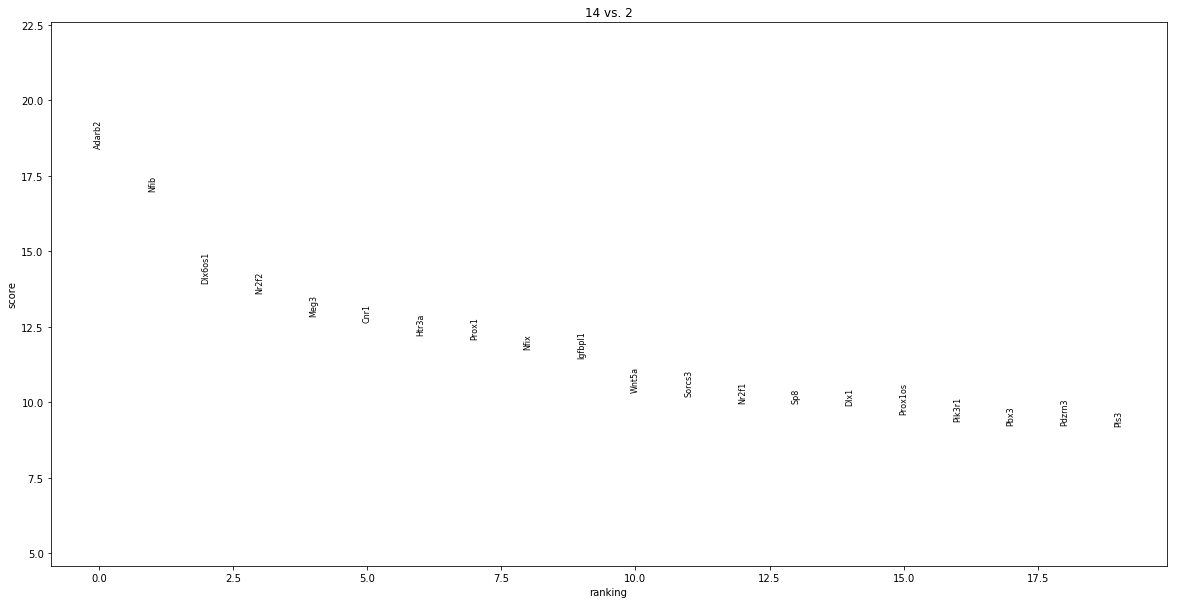

In [36]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['14'], reference='2')
sc.pl.rank_genes_groups(adata)

ranking genes
    finished (0:00:00.24) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


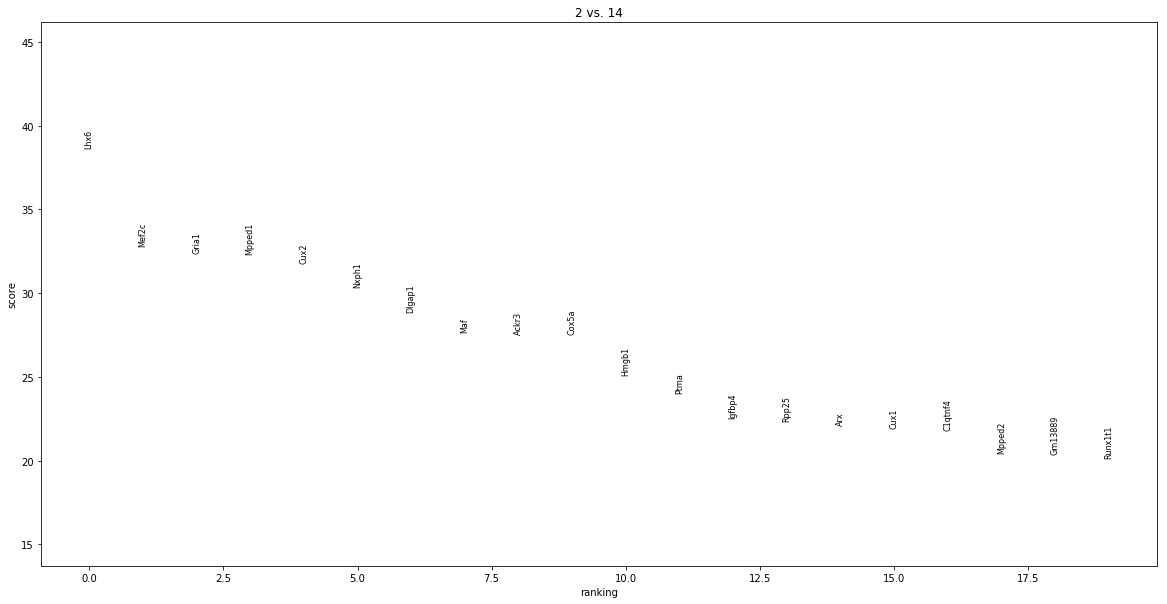

In [35]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['2'], reference='14')
sc.pl.rank_genes_groups(adata)

17 vs 14

ranking genes
    finished (0:00:00.18) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


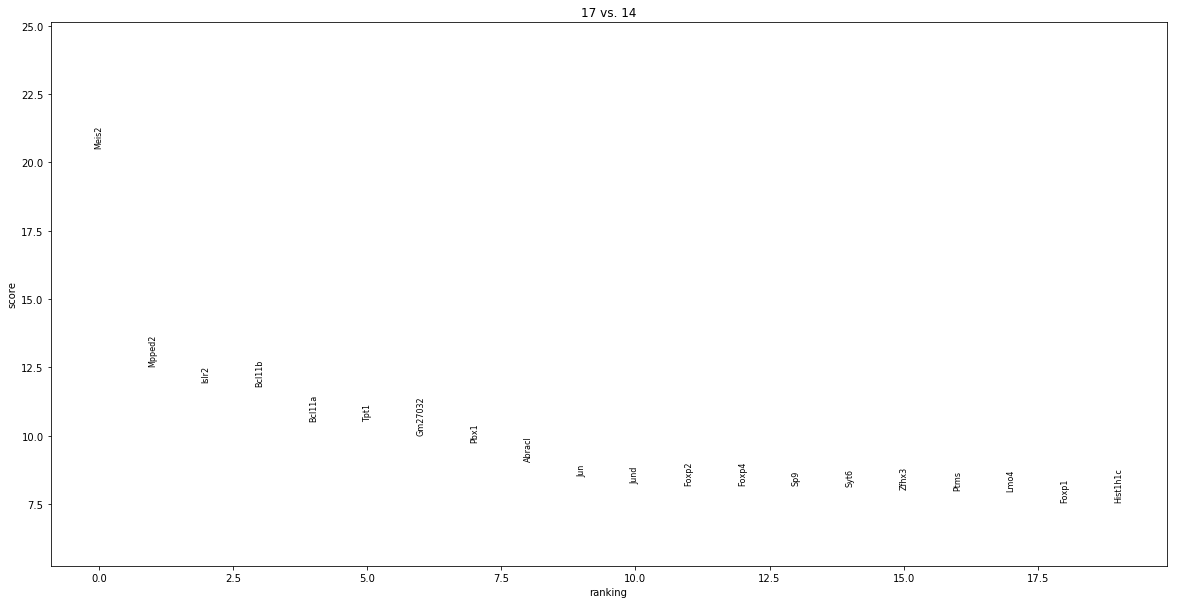

In [33]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['17'], reference='14')
sc.pl.rank_genes_groups(adata)

Adarb2 is VIP+ neuron marker

2 vs 17

ranking genes
    finished (0:00:00.27) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


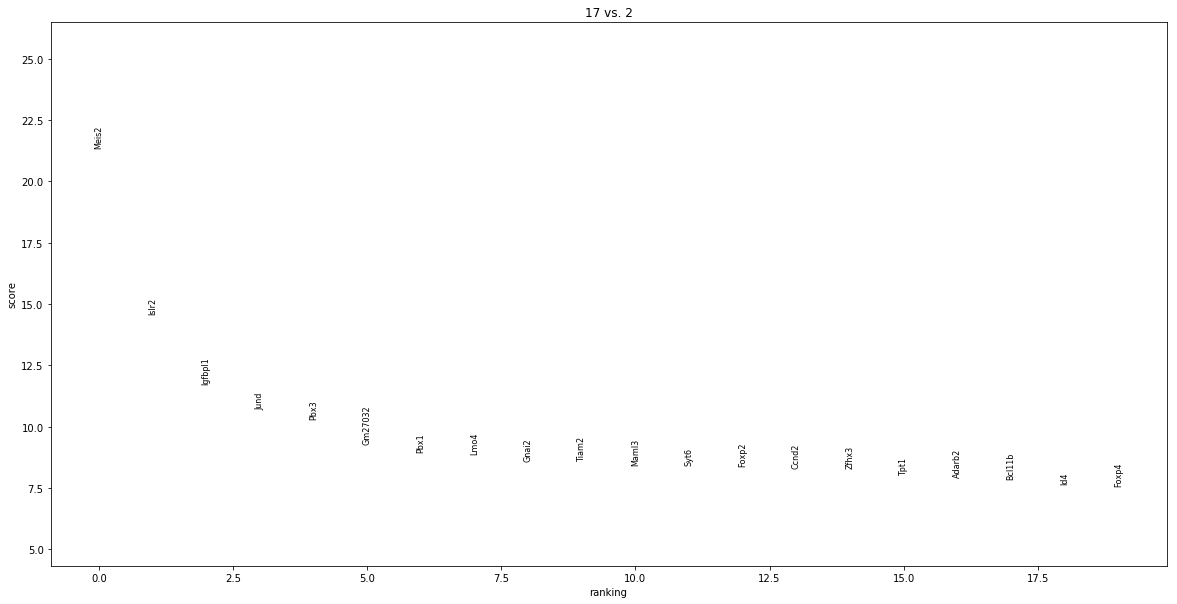

In [34]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['17'], reference='2')
sc.pl.rank_genes_groups(adata)

ranking genes
    finished (0:00:00.22) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


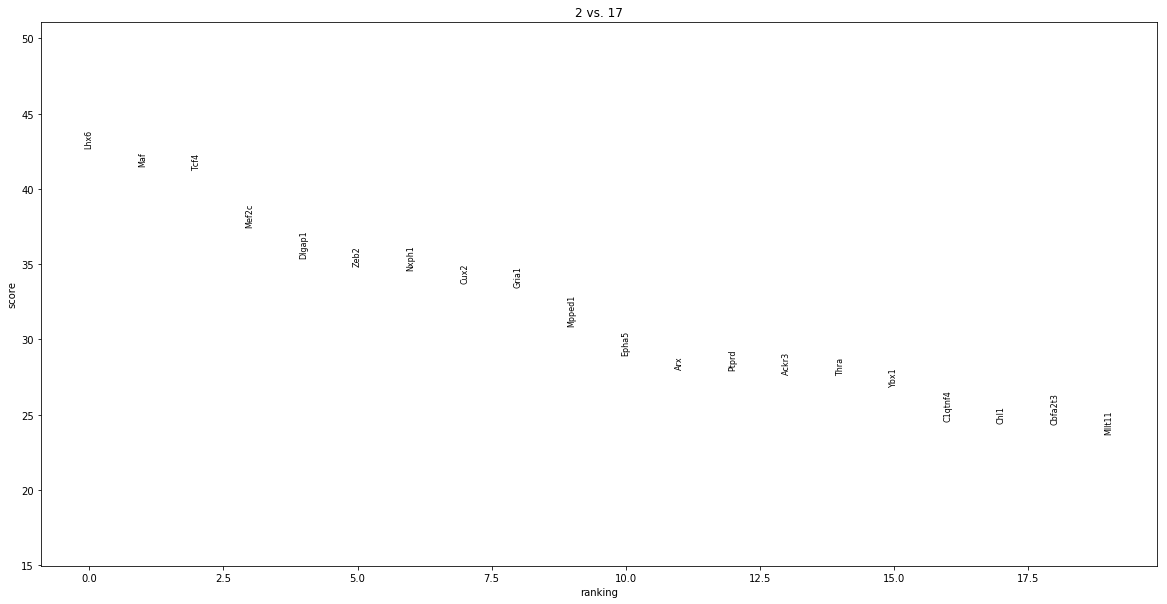

In [48]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['2'], reference='17')
sc.pl.rank_genes_groups(adata)

Pvalb marker

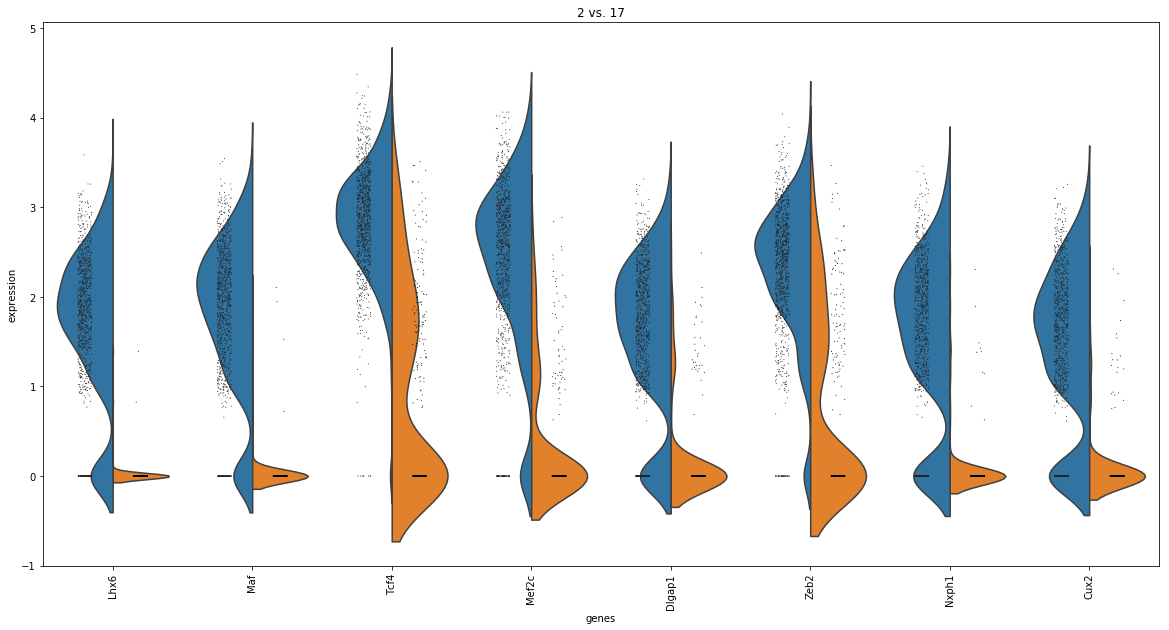

In [54]:
sc.pl.rank_genes_groups_violin(adata, groups='2', n_genes=8, use_raw=False)

running PAGA
    finished (0:00:00.54) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


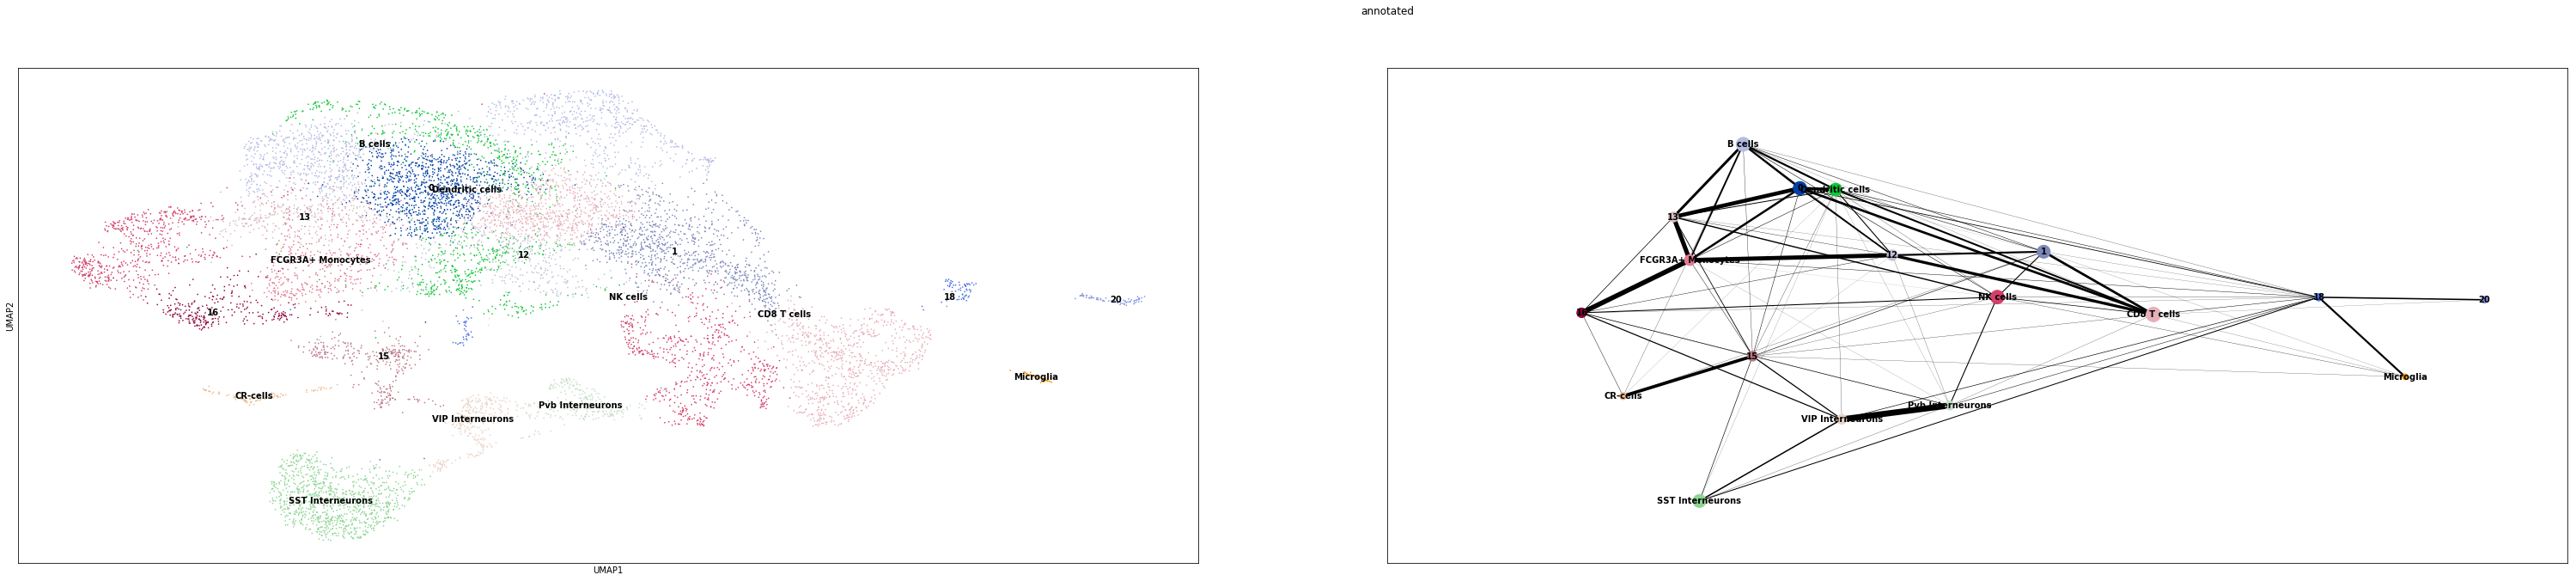

In [57]:
sc.tl.paga(adata = adata, groups='annotated')
sc.pl.paga_compare(adata = adata, basis='umap', frameon=True)

## Non-Neuronal Cells

In [59]:
marker_genes = ['Vim','Sox2','Nes','Pax6','Rspo2','Ccnd1','Eomes','Ccnd2','Cux1','Cux2','Gfap','S100b','Slc1a3','Pdgfra','Olig1','Olig2','Tubb3','Map2','Dcx','Gad1']


In [60]:
np.in1d(marker_genes, adata.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

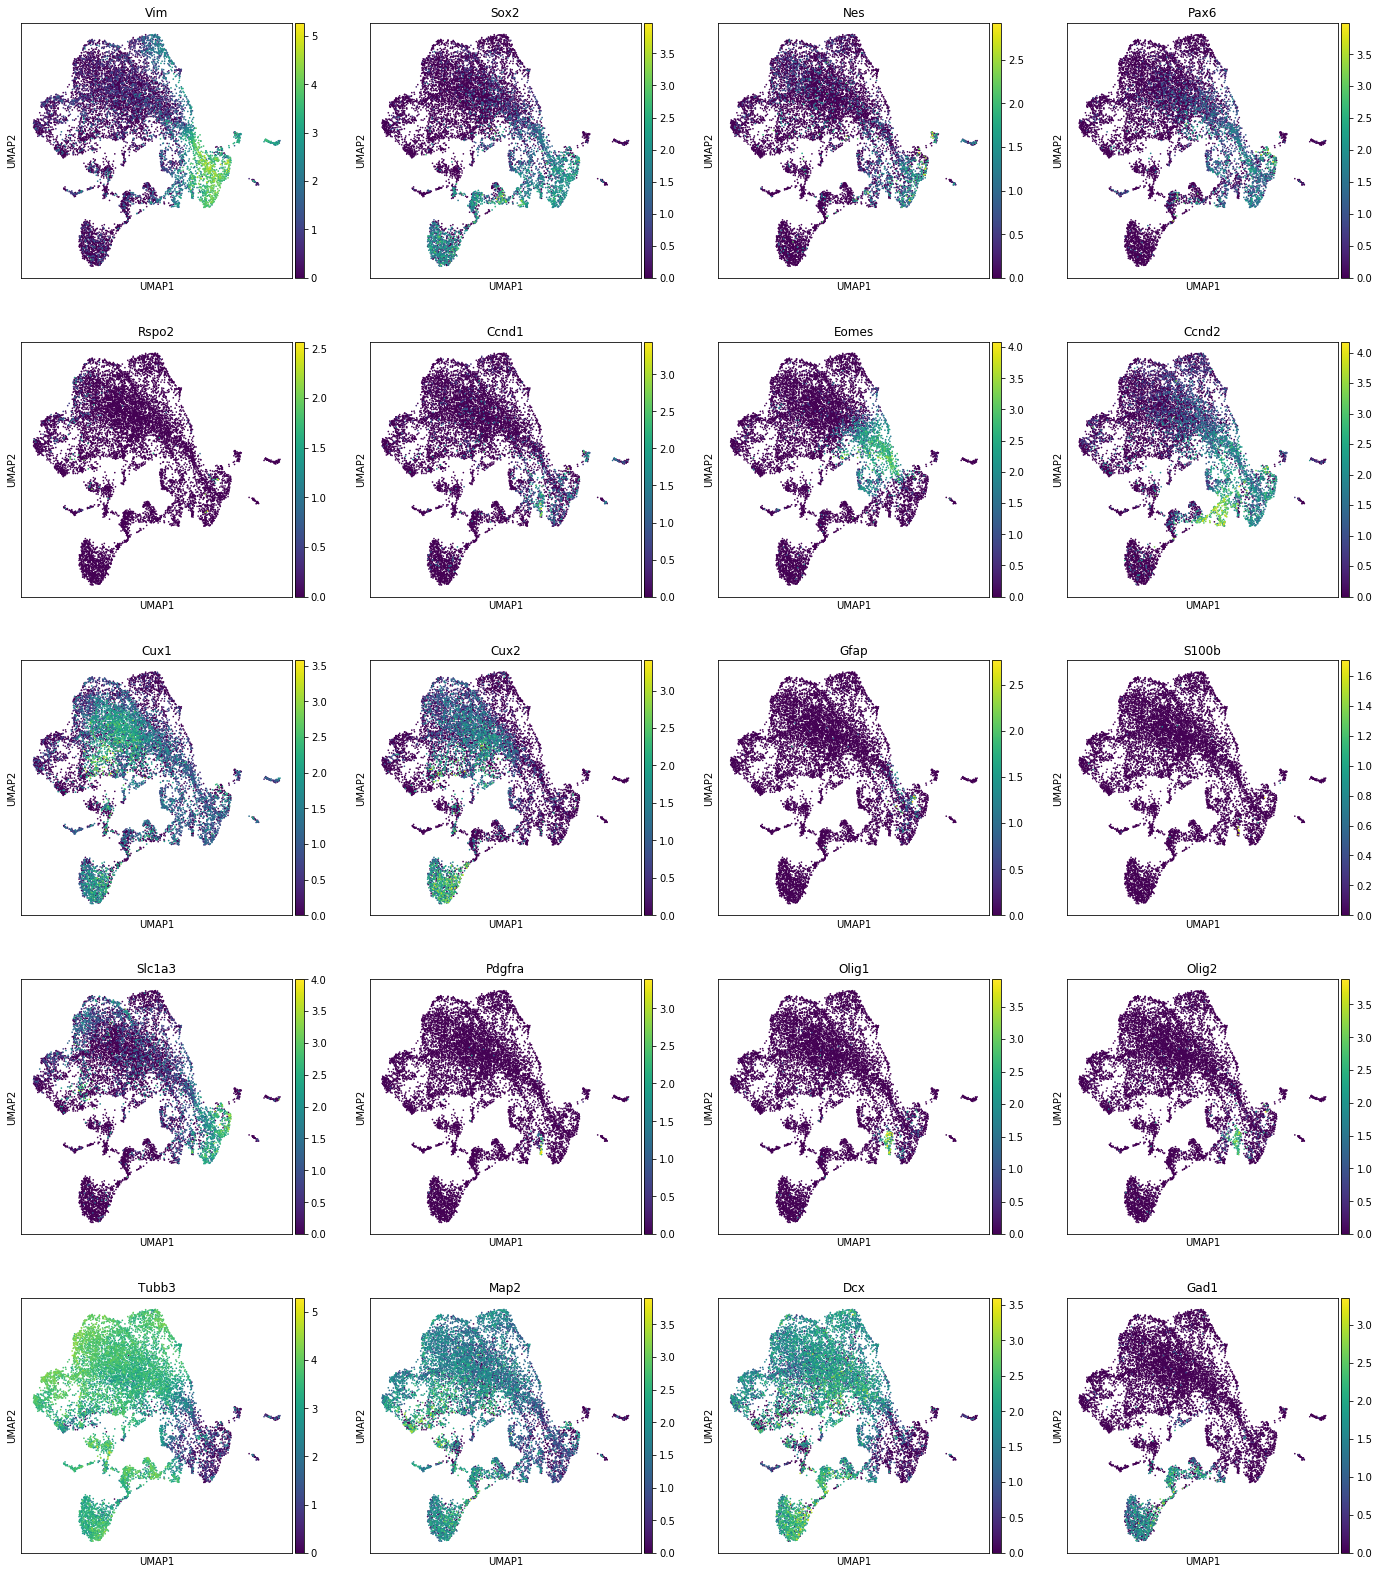

In [61]:
sc.pl.umap(adata=adata, color=marker_genes, use_raw=False)

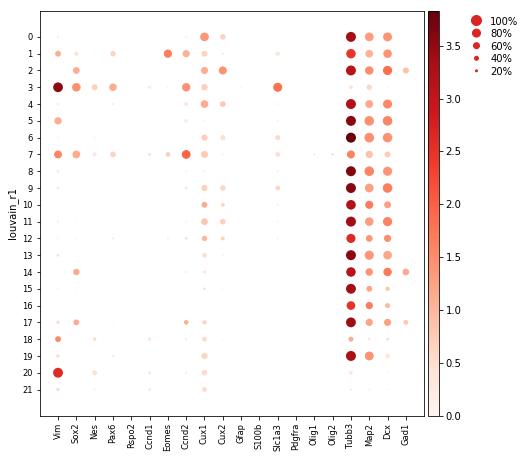

Divergent color map has been automatically set to plot non-raw data. Use `vmin`, `vmax` and `cmap` to adjust the plot.


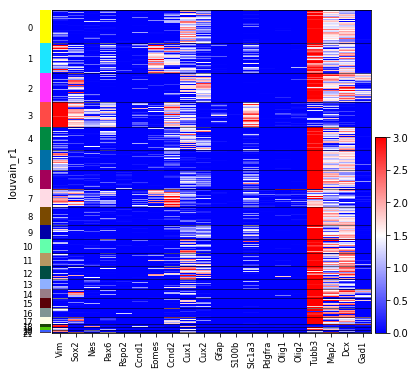

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 6.0, 0, 0.2])

In [62]:
np.in1d(marker_genes, adata.var_names)

ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain_r1', use_raw=False)

sc.pl.heatmap(adata=adata, var_names=marker_genes, 
              groupby='louvain_r1', use_raw=False, vmin=0)

#ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1', use_raw=False)

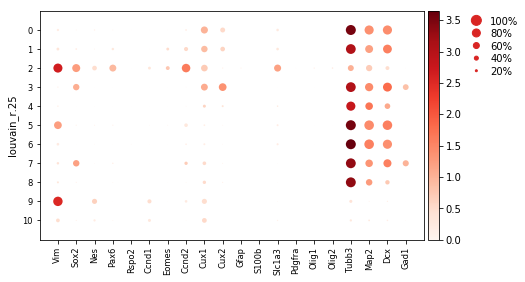

Divergent color map has been automatically set to plot non-raw data. Use `vmin`, `vmax` and `cmap` to adjust the plot.


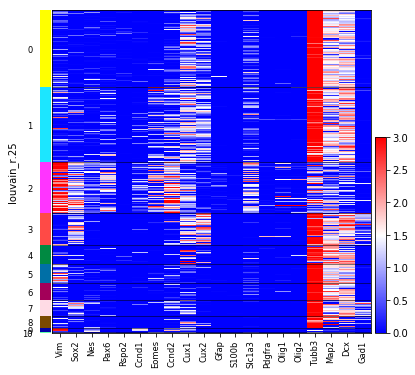

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 6.0, 0, 0.2])

In [63]:
np.in1d(marker_genes, adata.var_names)

ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain_r.25', use_raw=False)

sc.pl.heatmap(adata=adata, var_names=marker_genes, 
              groupby='louvain_r.25', use_raw=False, vmin=0)

#ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1', use_raw=False)

1 expresses IP markers Tbr2 (Eomes) and CyclinD2
3 expresses ventricular markers Vimentin, Sox2, Nestin, Pax6,

ranking genes
    finished (0:00:00.52) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


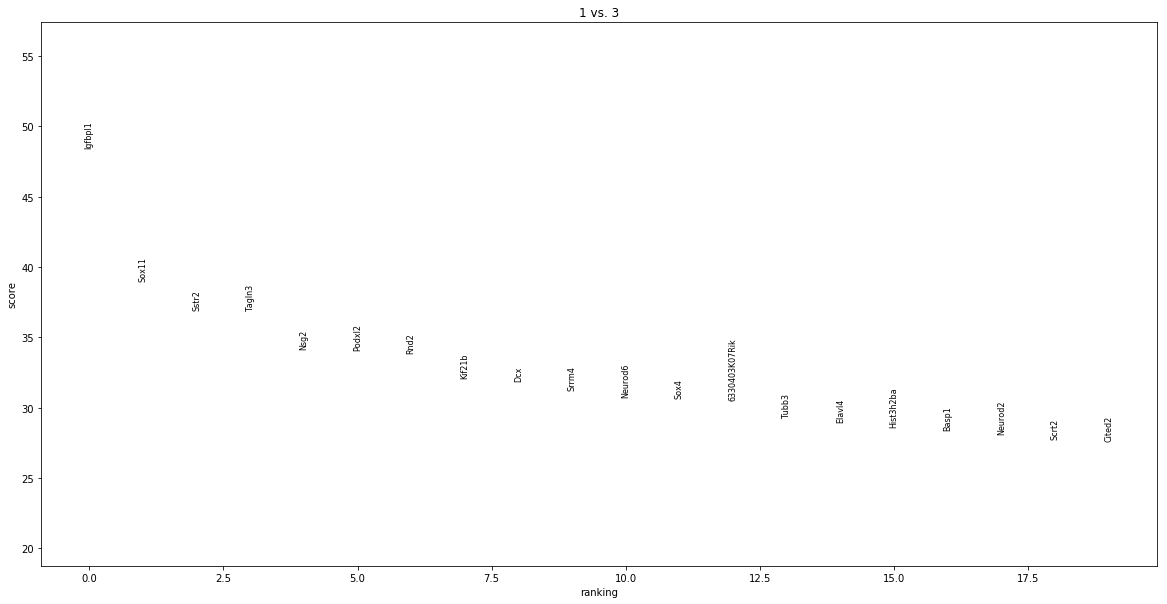

In [84]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['1'], reference='3')
sc.pl.rank_genes_groups(adata)

ranking genes
    finished (0:00:00.37) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


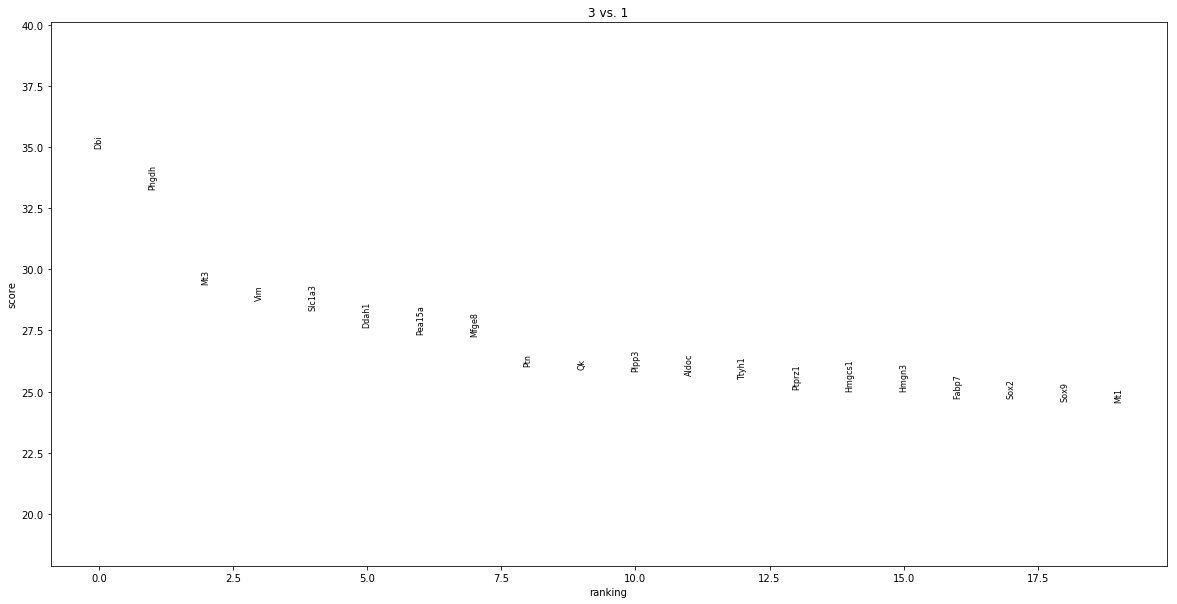

In [86]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['3'], reference='1')
sc.pl.rank_genes_groups(adata)

7 vs 1

ranking genes
    finished (0:00:00.33) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


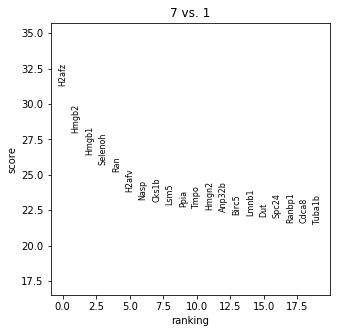

In [29]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['7'], reference='1')
sc.pl.rank_genes_groups(adata)

ranking genes
    finished (0:00:00.30) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


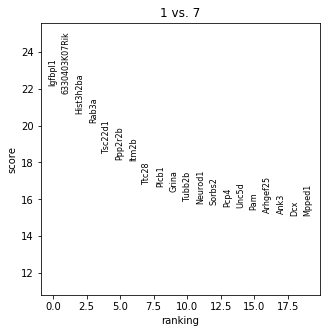

In [30]:
sc.tl.rank_genes_groups(adata = adata, groupby='louvain_r1', groups= ['1'], reference='7')
sc.pl.rank_genes_groups(adata)

## Laminar Markers

In [64]:
marker_genes = ['Rasgrf2','Crym','Bcl11b','Tbr1','Otx1','Tle4','Fezf2','Satb2','Foxp2','Cux1','Cux2','Pou3f2','Pou3f3','Olig1','Olig2','Tubb3','Map2','Dcx']

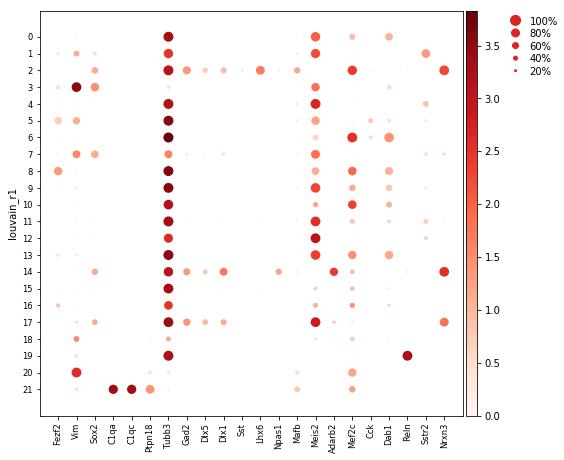

Divergent color map has been automatically set to plot non-raw data. Use `vmin`, `vmax` and `cmap` to adjust the plot.


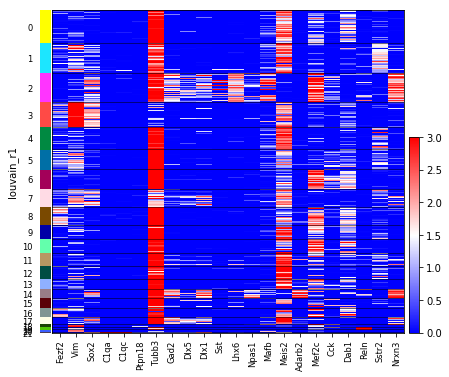

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 6.6, 0, 0.2])

In [21]:
np.in1d(marker_genes, adata.var_names)

ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain_r1', use_raw=False)

sc.pl.heatmap(adata=adata, var_names=marker_genes, 
              groupby='louvain_r1', use_raw=False, vmin=0)

#ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r1', use_raw=False)

In [ ]:
np.in1d(marker_genes, adata.var_names)

ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain_r.25', use_raw=False)

sc.pl.heatmap(adata=adata, var_names=marker_genes, 
              groupby='louvain_r.25', use_raw=False, vmin=0)

ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain_r.25', use_raw=False)

Deep layer markers 5, 8
0,4,

running PAGA
    finished (0:00:00.55) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


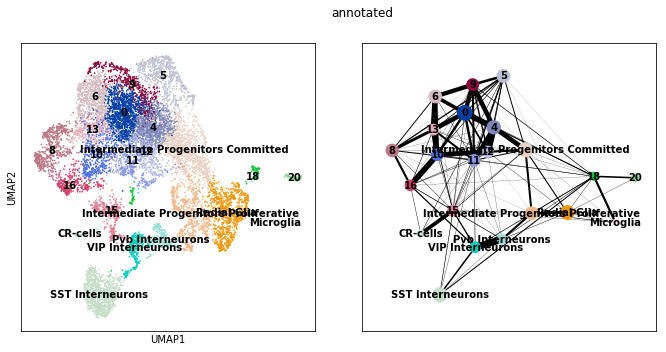

In [31]:
sc.tl.paga(adata = adata, groups='annotated')
sc.pl.paga_compare(adata = adata, basis='umap', frameon=True)

## Psuedotime

In [32]:
adata_prog = adata[np.in1d(adata.obs['annotated'], 
                           ['Intermediate Progenitors Committed', 'Intermediate Progenitors Proliferative', 'Radial Glia'])].copy()

In [33]:
adata_prog

AnnData object with n_obs × n_vars = 2436 × 15044 
    obs: 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'annotated'
    var: 'gene_ids', 'genome', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain_r1_colors', 'annotated_sizes', 'rank_genes_r1', 'paga', 'rank_genes_r0.5', 'draw_graph', 'louvain', 'rank_genes_groups', 'pca', 'phase_colors', 'diffmap_evals', 'neighbors', 'louvain_r0.5_colors', 'annotated_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'

In [36]:
adata_prog.uns['iroot'] = np.flatnonzero(adata_prog.obs['annotated']=='Radial Glia')[3]
sc.tl.dpt(adata = adata_prog)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


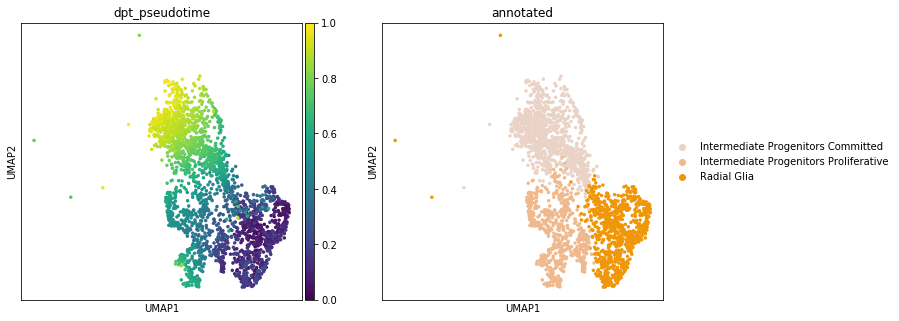

In [37]:
sc.pl.umap(adata_prog, color=['dpt_pseudotime', 'annotated'])